# FairTorch Demo Using the FairFace Dataset
In this demo, we predict the gender of people from their pictures, and demonstrate usage of FairTorch tools for evaluating and ensuring fairness across sensitive attributes, in this case race.

<pre>
File tree for this demo:
|--Fairface_Demo.ipynb (this notebook)
  |--fairface_dataset
    |--fairface_label_train.csv
    |--fairface_label_val.csv
    |--train
      |--a ton of training images
    |--val
      |--a ton of testing images
</pre>

### Import Dataset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image

In [2]:
class FFDataset:
    def __init__(self, train):
        self.train = train
        
        # skip header
        if self.train:
            filename = "./fairface_dataset/fairface_label_train.csv"
        else:
            filename = "./fairface_dataset/fairface_label_val.csv"
        with open(filename) as f:
            self.header_length = len(next(f))
        
        # set first line of data
        self.current_char = self.header_length
        
        self.n_epochs = 0
    
    def reset(self, f):
        """resets the file to the first line of data"""
        f.seek(self.header_length)
        self.current_char = self.header_length
        self.n_epochs += 1
    
    def get_n_epochs(self):
        return self.n_epochs
    
    def get_n_lines(self):
        return 86744 if self.train else 10954
    
    def get_data(self, n):
        """Returns the next n lines of data, resetting current_char if necessary"""
        if self.train:
            filename = "./fairface_dataset/fairface_label_train.csv"
        else:
            filename = "./fairface_dataset/fairface_label_val.csv"
        
        X = []
        y = []
        g = []
        
        with open(filename) as f:
            f.seek(self.current_char)
            i = 0
            while i < n:
                try:
                    line = next(f)
                except StopIteration:
                    self.reset(f)
                    line = next(f)
                
                img_path, age, gender, race, _ = line.split(',')
                
                img = Image.open(f"./fairface_dataset/{img_path}")
                img = np.array(img)
                img = (img - np.mean(img)) / np.std(img)
                
                X.append(img)
                y.append(0) if gender == "Male" else y.append(1)
                g.append(race)
                
                self.current_char += len(line)
                i += 1

        X, y, g = np.array(X, dtype=np.float32), np.array(y, dtype=np.long), np.array(g)
        return torch.from_numpy(X).permute(0, 3, 1, 2), torch.from_numpy(y), g

data = FFDataset(train=True)

X, y, g = data.get_data(1)

print(X.shape)
print(y[0], g[0])
plt.imshow((X[0].permute(1, 2, 0) - torch.min(X[0])) / (torch.max(X[0]) - torch.min(X[0])))
plt.show()

data = FFDataset(train=False)

X, y, g = data.get_data(100)
print(torch.sum(y))

FileNotFoundError: [Errno 2] No such file or directory: './fairface_dataset/fairface_label_train.csv'

### Define Model

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 7)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 5, 7)
        self.fc1 = nn.Linear(5 * 51 * 51, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 51 * 51)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Train Model

========================================BEGIN TRAINING========================================
|  [Epoch: 1, Batch: 10/868]	Train loss: 0.696	|  Test accuracy: 0.550	|
|  [Epoch: 1, Batch: 20/868]	Train loss: 0.691	|  Test accuracy: 0.550	|
|  [Epoch: 1, Batch: 30/868]	Train loss: 0.680	|  Test accuracy: 0.600	|
|  [Epoch: 1, Batch: 40/868]	Train loss: 0.673	|  Test accuracy: 0.640	|
|  [Epoch: 1, Batch: 50/868]	Train loss: 0.669	|  Test accuracy: 0.630	|
|  [Epoch: 1, Batch: 60/868]	Train loss: 0.662	|  Test accuracy: 0.630	|
|  [Epoch: 1, Batch: 70/868]	Train loss: 0.655	|  Test accuracy: 0.620	|
|  [Epoch: 1, Batch: 80/868]	Train loss: 0.647	|  Test accuracy: 0.660	|
|  [Epoch: 1, Batch: 90/868]	Train loss: 0.640	|  Test accuracy: 0.660	|
|  [Epoch: 1, Batch: 100/868]	Train loss: 0.633	|  Test accuracy: 0.670	|
|  [Epoch: 1, Batch: 110/868]	Train loss: 0.629	|  Test accuracy: 0.710	|
|  [Epoch: 1, Batch: 120/868]	Train loss: 0.625	|  Test accuracy: 0.690	|
|  [Epoch: 1, Batch: 130/8

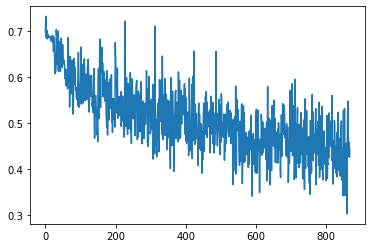

In [8]:
# set up validation data
test_data = FFDataset(train=False)
X_test, y_test, g_test = test_data.get_data(100)

# set up data and model then train
data = FFDataset(train=True)
model = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

epochs = 1

batch_size = 100
train_losses, test_losses = [], []

print_batch_freq = 10
batches_per_epoch = int(data.get_n_lines() / batch_size) + 1

print(40 * "=" + "BEGIN TRAINING" + 40 * "=")

running_loss, last_epoch, cur_batch = (0, 0, 0)
last_epoch = 0
while data.get_n_epochs() < epochs:
    if data.get_n_epochs() > last_epoch:
        cur_batch = 1
        running_loss = 0
    else:
        cur_batch += 1
    
    X, y, g = data.get_data(batch_size)

    optimizer.zero_grad()

    y_ = model(X)
    loss = criterion(y_, y)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    running_loss += loss.item()
    
    if len(train_losses) % print_batch_freq == print_batch_freq - 1:
        model.eval()
        accuracy = torch.mean((torch.argmax(model(X_test), axis=1) == y_test) * 1.)
        
        print(f"|  [Epoch: {data.get_n_epochs() + 1}, Batch: {cur_batch + 1}/{batches_per_epoch}]"
              f"\tTrain loss: {running_loss/cur_batch:.3f}\t|"
              f"  Test accuracy: {accuracy:.3f}\t|")
        model.train()
        
print(41 * "=" + "END TRAINING" + 41 * "=")

plt.plot(train_losses, label='Training loss')
plt.show()

In [27]:
total, correct = (0, 0)
while test_data.get_n_epochs() < 1:
    X_test, y_test, g_test = test_data.get_data(100)
    total += 100
    correct += torch.sum((torch.argmax(model(X_test), axis=1) == y_test) * 1.)
print((correct / total).item())

0.7735999822616577


# FairTorch Metrics Examples

In [3]:
import sys
sys.path.append("../../api")

from evaluation import metrics

In [29]:
X, y, group = test_data.get_data(500)
y_ = torch.argmax(model(X), axis=-1)

print("True Positives:", metrics.true_pos(y_.detach().view(-1), y.detach().view(-1), group))
print("\nFalse Positive Rate:", metrics.false_pos_rate(y_.detach().view(-1), y.detach().view(-1), group))
print("\nDemographic Parity:", metrics.Demographic_Parity(y_.detach().view(-1), y.detach().view(-1), group, "White"))

True Positives: {'Black': 24, 'East Asian': 22, 'Indian': 21, 'Latino_Hispanic': 36, 'Middle Eastern': 21, 'Southeast Asian': 19, 'White': 48}

False Positive Rate: {'Black': 0.21052631578947367, 'East Asian': 0.005190311418685122, 'Indian': 7, 'Latino_Hispanic': 0.006055363321799308, 'Middle Eastern': 0.13953488372093023, 'Southeast Asian': 7, 'White': 0.3018867924528302}

Demographic Parity: {'Black': 0.6352941176470588, 'East Asian': 0.5882352941176471, 'Indian': 0.49411764705882355, 'Latino_Hispanic': 0.7411764705882353, 'Middle Eastern': 0.6823529411764706, 'Southeast Asian': 0.49411764705882355, 'White': 1.0}
